# Shallow circulation analysis

How patterns of shallow convection are organizing is still an open question. By seeing parallels to the organization to deep convection, where a shallow circulation is increasing the difference between dry and moist regions ( working up-gradient), similar circulations might help to cluster the shallow pattern that recently have been named *Sugar, Gravel, Flowers, Fish*.

In order to investigate this circulation, and to quantify how much of such a potential circulation is radiatively driven circulation, a parallel analysis to the one in [Schulz et al. (2018)](https://doi.org/10.1175/JAS-D-17-0375.1) could be conducted with the data collected during EUREC$^4$A.

To be specific:
   - sorting profiles of moisture and radiative cooling from sources like radiosoundings, dropsondes, lidars (HALO, METEOR, BCO) by precipitable water
   - bin data by precipitable water
   - smoothing data
   - calculation of heating anomalies
   - calculating of radiatively driven circulations
   
This analysis could be split for the different patterns of meso-scale organizations to study the potential differences, that are potentially caused by different ranges of the moisture space ( *Sugar* small range of PW values; *Fish* high values of PW) or the different cloud field to name a few.

In combination to the radiatively driven circulations, the actually measured vertical velocities from e.g. the HALO circles could estimate the importans of the former.

Here is a quick and dirty starting point for the steps above:

In [1]:
fn_radiation_pw_sorted = './data/ds_radiation_sel_pw.nc'
overwrite = False

In [2]:
# Loading necessary modules
import tqdm
import os
import numpy as np

import xarray as xr

import scipy.ndimage
import scipy.signal

import metpy.calc as mpcalc

from metpy.units import units
import matplotlib.pyplot as plt

import circulation as circ
from deriv1d import deriv

## Computation of all necessary properties
- PW
- sorting by PW
- vertical velocity based on WTG
-...

In [3]:
if not os.path.exists(fn_radiation_pw_sorted) and overwrite is False:
    # Load radiation dataset
    try:
        ds_radiation = xr.open_dataset("https://observations.ipsl.fr/thredds/dodsC/EUREC4A/PRODUCTS/RADIATIVE-PROFILES/rad_profiles.nc", engine="pydap")
    except:
        ds_radiation = xr.open_dataset("./data/rad_profiles.nc")

    # Load radiation dataset into memory
    ds_radiation.load()

    # Remove duplicate timesteps (this drops about 6 soundings, 
    # where two platforms have launch a sonde at the same time)
    # For the fancy indixing, duplicates are causing errors, so
    # we remove those soundings from the dataset for simplicity
    _, uniq_ind = np.unique(ds_radiation.launch_time, return_index=True)
    ds_radiation_sel = ds_radiation.isel(launch_time = uniq_ind)

    # Calculation of precipitable water
    pw = np.empty(len(ds_radiation_sel.launch_time))
    pw.fill(np.nan)
    for s, snd in enumerate(tqdm.tqdm(ds_radiation_sel.launch_time)):
        # Only include soundings that went through the major part of the troposphere
        # Somehow the bottom and top arguments are not working here
        if ds_radiation_sel.isel(launch_time=s).pressure.min() <= 30000 and ds_radiation_sel.isel(launch_time=s).pressure.max() > 90000:
                dp = mpcalc.dewpoint_from_relative_humidity( ds_radiation_sel.isel(launch_time=s).temperature * units.kelvin,
                                                            ds_radiation_sel.isel(launch_time=s).relative_humidity/100)
                try:
                    pw[s] = mpcalc.precipitable_water(ds_radiation_sel.isel(launch_time=s).pressure * units.Pa,
                                              dp,
    #                                           bottom=850 * units.hPa,
    #                                           top=300 * units.hPa # for some reason not working here
                                             ).magnitude # in mm
                except ValueError:
                    pass

    ds_radiation_sel['pw'] = xr.DataArray(pw, dims=["launch_time"])
    
    # Remove soundings and heights that do not have a PW value
    pw_ind = np.where(ds_radiation_sel.pw > 0)[0]

    ds_radiation_sel_pw = ds_radiation_sel.isel(launch_time = pw_ind)
    # Remove all heights that contain any nan value
    ds_radiation_sel_pw = ds_radiation_sel_pw.dropna("alt")
    
    theta = mpcalc.potential_temperature(ds_radiation_sel_pw.pressure * units.Pa,
                                     ds_radiation_sel_pw.temperature * units.kelvin)
    ds_radiation_sel_pw["theta"] = theta
    dtheta_dp = np.empty((len(ds_radiation_sel_pw.launch_time), len(ds_radiation_sel_pw.alt)))
    dtheta_dp.fill(np.nan)
    for s, snd in enumerate(tqdm.tqdm(ds_radiation_sel_pw.launch_time)):
        dtheta_dp[s,:] = deriv(ds_radiation_sel_pw.isel(launch_time=s).pressure[::-1],
                               ds_radiation_sel_pw.isel(launch_time=s).theta[::-1])
    ds_radiation_sel_pw["dtheta_dp"] = xr.DataArray(dtheta_dp, dims = ["launch_time", "alt"])
    heating_anomaly = (ds_radiation_sel_pw.q_rad - np.nanmean(ds_radiation_sel_pw.q_rad,axis=0)) # axis 0 is altitude
    ds_radiation_sel_pw["heating_anomaly"] = xr.DataArray(heating_anomaly, dims = ["launch_time", "alt"])

    def smooth_field(data, window=(10,10)):
        """Apply gaussian filter to data
        """
        d_smoothed = scipy.ndimage.filters.gaussian_filter(data, window)
        return d_smoothed

    data_sorted = ds_radiation_sel_pw.sortby('pw').copy()
    for var in ['heating_anomaly', 'temperature', 'theta', 'dtheta_dp']:
         data_sorted[var+'_smooth'] =  (['alt', 'launch_time'], smooth_field(data_sorted[var].T))

    omega_clear_smooth = circ.wtg(data_sorted.temperature_smooth*units.kelvin,data_sorted.theta_smooth*units.kelvin,
                      data_sorted.heating_anomaly_smooth*units.kelvin/units.day,
                      data_sorted.dtheta_dp_smooth*units.kelvin/units.pascal)
    omega_clear = circ.wtg(ds_radiation_sel_pw.temperature*units.kelvin,ds_radiation_sel_pw.theta*units.kelvin,
                      ds_radiation_sel_pw.heating_anomaly *units.kelvin/units.day,
                      ds_radiation_sel_pw.dtheta_dp*units.kelvin/units.pascal)
    data_sorted["omega_clear_smooth"] = xr.DataArray(omega_clear_smooth.metpy.magnitude, dims = ["alt", "launch_time"])
    data_sorted["omega_clear"] = xr.DataArray(omega_clear.metpy.magnitude, dims = ["launch_time", "alt"])
    
    # Write to netcdf
    ds_dequantified = data_sorted.metpy.dequantify()
    for var in ds_dequantified.data_vars:
        ds_dequantified[var].encoding['zlib'] = True
    ds_dequantified.to_netcdf(fn_radiation_pw_sorted)

In [4]:
ds_dequantified = xr.open_dataset(fn_radiation_pw_sorted)

## Visualize data

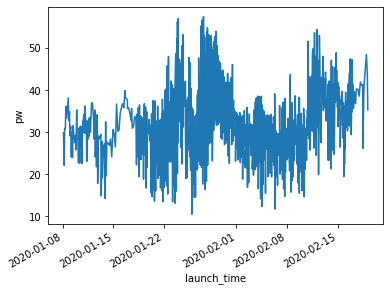

In [13]:
# Visualize precipitable water
ds_dequantified.pw.sortby('launch_time').plot()

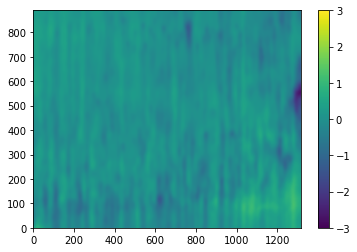

In [15]:
plt.pcolormesh(ds_dequantified.heating_anomaly_smooth, vmin=-3, vmax=3)
plt.colorbar();

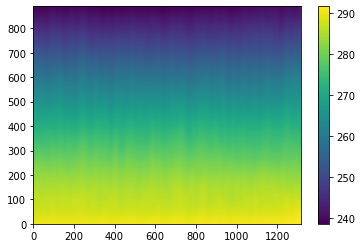

In [16]:
plt.pcolormesh(ds_dequantified.temperature_smooth)
plt.colorbar();

## Group data by PW
Single profiles contain too much noise, such that binning them helps to reduce that noise.

In [18]:
pw_bins = np.linspace(5,60,40)

In [19]:
# Group all data by precipitable water
ds_radiation_grp = ds_dequantified.groupby_bins("pw", pw_bins).mean()
ds_radiation_grp['profiles_per_bin'] = ds_dequantified.groupby_bins("pw", pw_bins).count().pw

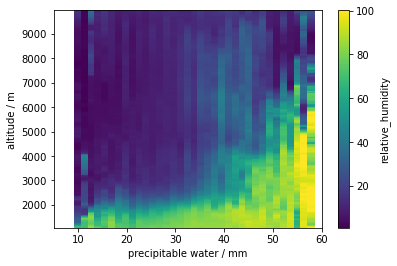

In [20]:
# Visualize the binned/grouped data
ds_radiation_grp.relative_humidity.T.plot()
plt.xlabel('precipitable water / mm')
plt.ylabel("altitude / m");

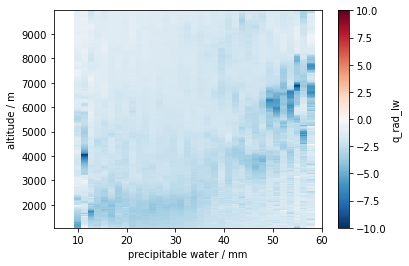

In [21]:
ds_radiation_grp.q_rad_lw.T.plot(vmin=-10,vmax=+10, cmap="RdBu_r")
plt.xlabel('precipitable water / mm')
plt.ylabel("altitude / m");

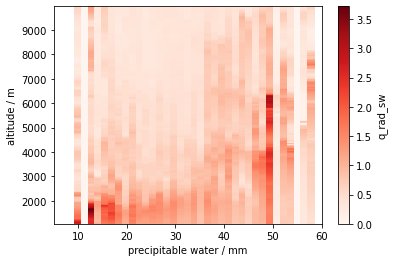

In [22]:
ds_radiation_grp.q_rad_sw.T.plot(cmap="Reds")
plt.xlabel('precipitable water / mm')
plt.ylabel("altitude / m");

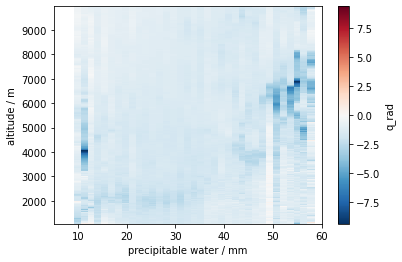

In [23]:
ds_radiation_grp.q_rad.T.plot(cmap="RdBu_r")
plt.xlabel('precipitable water / mm')
plt.ylabel("altitude / m");

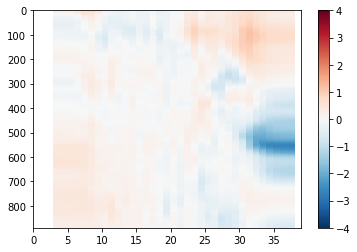

In [26]:
plt.pcolormesh(ds_radiation_grp.heating_anomaly_smooth.T, cmap="RdBu_r", vmin=-4, vmax=4)
plt.gca().invert_yaxis()
plt.colorbar()

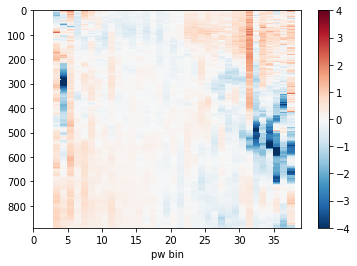

In [200]:
plt.pcolormesh(ds_radiation_grp.heating_anomaly.T, cmap="RdBu_r", vmin=-4, vmax=4)
plt.gca().invert_yaxis()
plt.colorbar()
plt.xlabel('pw bin');

In [29]:
heating_anomaly = (ds_radiation_mean.q_rad - np.nanmean(ds_radiation_mean.q_rad,axis=0)) # axis 0 is altitude
ds_radiation_mean["heating_anomaly_2"] = xr.DataArray(heating_anomaly, dims = ["pw_bins", "alt"])

<ipython-input-195-b9727faa9b4c>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(ds_radiation_mean.pw, ds_radiation_mean.pressure.mean(dim='pw_bins')/100, ds_radiation_mean.heating_anomaly_2.T, cmap="RdBu_r", vmin=-4, vmax=4)


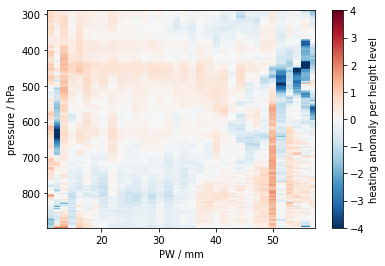

In [195]:
plt.pcolormesh(ds_radiation_mean.pw, ds_radiation_mean.pressure.mean(dim='pw_bins')/100, ds_radiation_mean.heating_anomaly_2.T, cmap="RdBu_r", vmin=-4, vmax=4)
plt.gca().invert_yaxis()
plt.xlabel("PW / mm")
plt.ylabel("pressure / hPa")
plt.colorbar(label='heating anomaly per height level');

In [31]:
omega_clear_2 = circ.wtg(ds_radiation_mean.temperature*units.kelvin,ds_radiation_mean.theta*units.kelvin,
                  ds_radiation_mean.heating_anomaly_2 *units.kelvin/units.day,
                  ds_radiation_mean.dtheta_dp*units.kelvin/units.pascal)
ds_radiation_mean["omega_clear_2"] = xr.DataArray(omega_clear_2.metpy.magnitude, dims = ["pw_bins", "alt"])

In [324]:
ds_radiation_mean

<xarray.Dataset>
Dimensions:                 (alt: 890, alt_edges: 1001, pw_bins: 35)
Coordinates:
  * alt                     (alt) int64 1065 1075 1085 1095 ... 9935 9945 9955
  * pw_bins                 (pw_bins) object (9.231, 10.641] ... (57.179, 58.59]
  * alt_edges               (alt_edges) int32 0 10 20 30 ... 9980 9990 10000
Data variables:
    latitude                (pw_bins, alt) float64 12.02 12.02 ... 9.194 9.194
    longitude               (pw_bins, alt) float64 -56.57 -56.57 ... -54.27
    z_min                   (pw_bins) float64 680.0 1e+03 855.0 ... 73.33 40.0
    z_max                   (pw_bins) float64 2.271e+04 2.539e+04 ... 2.33e+04
    temperature             (pw_bins, alt) float64 292.4 292.3 ... 242.5 242.5
    pressure                (pw_bins, alt) float64 9.006e+04 ... 2.899e+04
    specific_humidity       (pw_bins, alt) float64 0.01688 0.01691 ... 0.0004205
    pressure_edges          (pw_bins, alt_edges) float64 nan nan ... 2.882e+04
    sfc_emis                (pw_bins) float64 0.98 0.98 0.98 ... 0.98 0.98 0.98
    sfc_alb                 (pw_bins) float64 0.07 0.07 0.07 ... 0.07 0.07 0.07
    sfc_temperature         (pw_bins) float64 300.0 299.5 300.0 ... 299.7 300.0
    cos_sza                 (pw_bins) float64 0.3381 0.0 0.4464 ... 0.105 0.1745
    lw_dn                   (pw_bins, alt_edges) float64 nan nan ... 65.0 64.81
    lw_up                   (pw_bins, alt_edges) float64 nan nan ... 301.2 301.1
    lw_net                  (pw_bins, alt_edges) float64 nan nan ... -236.3
    sw_dn                   (pw_bins, alt_edges) float64 nan nan ... 202.3 202.3
    sw_up                   (pw_bins, alt_edges) float64 nan nan ... 27.02 27.03
    sw_net                  (pw_bins, alt_edges) float64 nan nan ... 175.3 175.3
    relative_humidity       (pw_bins, alt) float64 66.5 66.86 ... 25.14 25.49
    wind_speed              (pw_bins, alt) float64 1.403 1.446 ... 13.69 13.62
    wind_direction          (pw_bins, alt) float64 58.89 60.4 ... 251.3 251.0
    u_wind                  (pw_bins, alt) float64 -1.201 -1.258 ... 12.97 12.88
    v_wind                  (pw_bins, alt) float64 -0.7245 -0.7137 ... 4.434
    co2                     (pw_bins, alt) float64 0.00036 0.00036 ... 0.00036
    ch4                     (pw_bins, alt) float64 1.7e-06 1.7e-06 ... 1.683e-06
    n2o                     (pw_bins, alt) float64 3.2e-07 3.2e-07 ... 3.177e-07
    o3                      (pw_bins, alt) float64 3.129e-08 ... 5.642e-08
    o2                      (pw_bins, alt) float64 0.209 0.209 ... 0.209 0.209
    n2                      (pw_bins, alt) float64 0.7906 0.7906 ... 0.7906
    co                      (pw_bins, alt) float64 1.449e-07 ... 1.005e-07
    mr                      (pw_bins, alt) float64 0.0105 0.01053 ... 0.0002617
    rho                     (pw_bins, alt) float64 1.066 1.065 ... 0.417 0.4165
    q_rad                   (pw_bins, alt) float64 -2.454 -2.363 ... -2.13
    q_rad_lw                (pw_bins, alt) float64 -4.985 -4.931 ... -2.727
    q_rad_sw                (pw_bins, alt) float64 2.532 2.568 ... 0.5913 0.5979
    pw                      (pw_bins) float64 10.53 11.75 12.75 ... 56.56 57.42
    theta                   (pw_bins, alt) float64 301.3 301.3 ... 345.3 345.4
    dtheta_dp               (pw_bins, alt) float64 -0.0001711 ... -3.429e-05
    heating_anomaly         (pw_bins, alt) float64 -1.005 -0.9026 ... -1.008
    heating_anomaly_smooth  (pw_bins, alt) float64 0.3731 0.3691 ... -0.5958
    temperature_smooth      (pw_bins, alt) float64 290.1 290.1 ... 241.3 241.3
    theta_smooth            (pw_bins, alt) float64 300.0 300.0 ... 342.7 342.7
    dtheta_dp_smooth        (pw_bins, alt) float64 -0.0006249 ... -0.0006318
    omega_clear_smooth      (pw_bins, alt) float64 -0.007148 ... 0.0155
    omega_clear             (pw_bins, alt) float64 0.05827 0.01909 ... 0.002528
    profiles_per_bin        (pw_bins) float64 1.0 1.0 2.0 10.0 ... 2.0 3.0 1.0
    heating_anomaly_2       (pw_b

In [325]:
# # smooth specific fields
omega_clear_smooth = scipy.ndimage.filters.gaussian_filter(ds_radiation_mean.omega_clear_2.T,(20,2))
# Q_anomaly_smooth = scipy.ndimage.filters.gaussian_filter(ds_radiation_mean.heating_anomaly_2.T,(20,2))
Q_anomaly_smooth = scipy.ndimage.filters.gaussian_filter(ds_radiation_mean.q_rad.T,(20,2))

In [302]:
omega_clear_smooth_anomaly_all = omega_clear_smooth.T-np.mean(omega_clear_smooth,axis=1)
Q_anomaly_smooth_anomaly_all = Q_anomaly_smooth.T-np.mean(Q_anomaly_smooth, axis=1)  # this is incorrect, Q_anomaly must be calculated again
omega_clear_smooth_anomaly_sel = omega_clear_smooth[:,6:25].T-np.mean(omega_clear_smooth[:,6:25],axis=1)  # excluding extreme bins with few profiles
Q_anomaly_smooth_anomaly_sel = Q_anomaly_smooth[:,6:25].T-np.mean(Q_anomaly_smooth[:,6:25], axis=1)  # this is incorrect, Q_anomaly must be calculated again

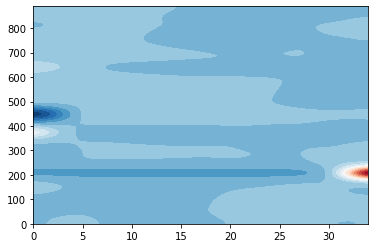

In [303]:
plt.contourf(omega_clear_smooth_anomaly_all.T, levels=20, cmap="RdBu")

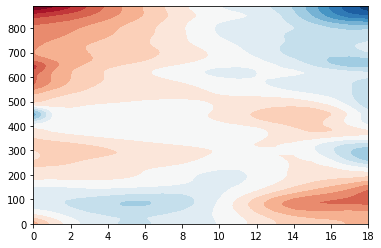

In [304]:
plt.contourf(omega_clear_smooth_anomaly_sel.T, levels=20, cmap="RdBu")

In [305]:
psi_smooth = circ.streamfunction_p(omega_clear_smooth_anomaly_sel,ds_radiation_mean.pressure.mean(dim="pw_bins"),
#                        firstProfile=np.mean(omega_clear_smooth_anomaly,0),
                       alpha=1./ds_radiation_mean.heating_anomaly.T.shape[1])

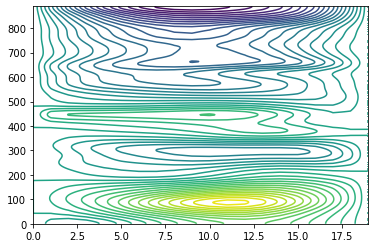

In [306]:
plt.contour(psi_smooth.T, levels=40)

In [307]:
# psi_smooth = circ.streamfunction_p(ds_radiation_mean.omega_clear_smooth.T.metpy.magnitude,ds_radiation_mean.pressure.mean(dim="pw_bins"),
#                        firstProfile=np.mean(ds_radiation_mean.omega_clear_smooth.T,0).metpy.magnitude,
#                        alpha=1./len(ds_radiation_mean.heating_anomaly.T.metpy.magnitude))

In [308]:
# psi = circ.streamfunction_p(omega_clear_smooth.T,ds_radiation_mean.pressure.mean(dim="pw_bins"),
#                        firstProfile=np.mean(omega_clear_smooth.T,0),
#                        alpha=1./len(ds_radiation_mean.heating_anomaly))

In [309]:
# # psi = circ.streamfunction_p(omega_clear_2,ds_radiation_mean.pressure.mean(dim="pw_bins"),
#                        firstProfile=np.mean(omega_clear_2,0),
#                        alpha=1./len(ds_radiation_mean.heating_anomaly))

In [310]:
np.shape(omega_clear_2.metpy.magnitude*860.)

(35, 890)

<ipython-input-311-54f0c723f171>:6: UserWarning: The following kwargs were not used by contour: 'interpolation'
  p1  = ax.contourf(ds_radiation_mean.pw,ds_radiation_mean.pressure.mean(dim="pw_bins")/100,


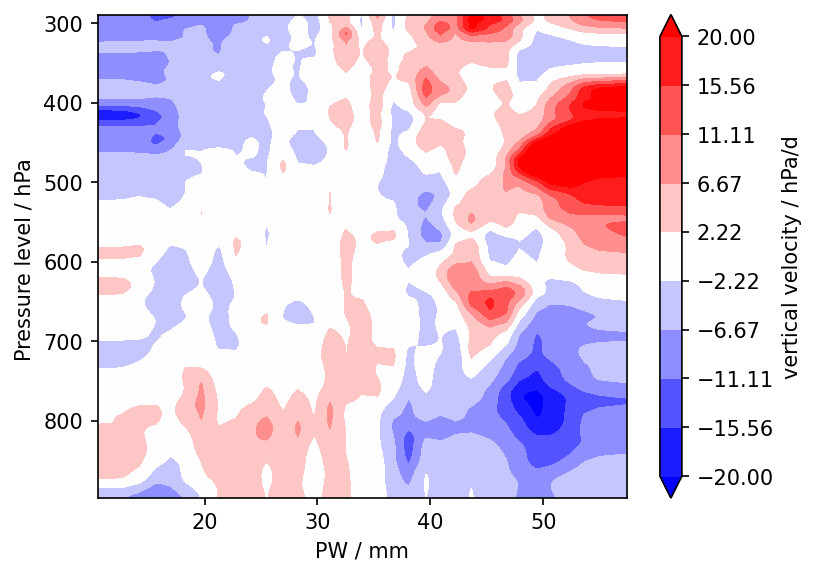

In [311]:
fig = plt.figure(figsize=(5.69,4.27), dpi=150)
ax  = plt.subplot(111)
bound = np.nanmax([np.abs(np.nanpercentile(ds_radiation_mean.omega_clear_smooth.T.metpy.magnitude*860.,1)),
                   np.abs(np.nanpercentile(ds_radiation_mean.omega_clear_smooth.T.metpy.magnitude*860.,99))])
bound = 20
p1  = ax.contourf(ds_radiation_mean.pw,ds_radiation_mean.pressure.mean(dim="pw_bins")/100,
                  ds_radiation_mean.omega_clear_smooth.T.metpy.magnitude*860.,cmap="bwr",levels=np.linspace(-bound,+bound,10),
                  interpolation="none",extend="both")
# plt.gca().invert_yaxis()
# ax.set_xlabel(r'Percentile of IWV')
# ax.set_xticklabels(['0','20','40','60','80','100'])

ax.set_ylabel("Pressure level / hPa ")
ax.set_xlabel("PW / mm")
ax.invert_yaxis()
c1 = plt.colorbar(p1)
c1.set_label("vertical velocity / hPa/d")

<ipython-input-312-e6bf0d5c47ab>:6: UserWarning: The following kwargs were not used by contour: 'interpolation'
  p1  = ax.contourf(ds_radiation_mean.pw,ds_radiation_mean.pressure.mean(dim="pw_bins")/100,


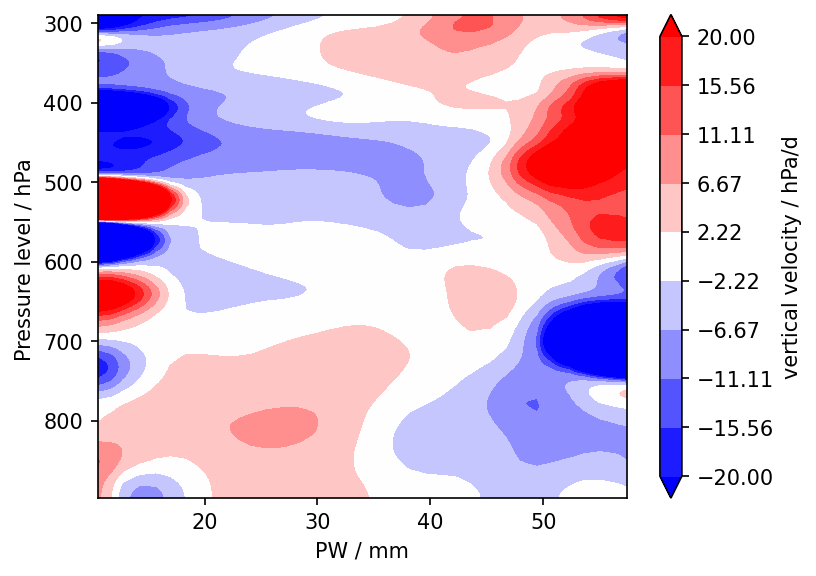

In [312]:
fig = plt.figure(figsize=(5.69,4.27), dpi=150)
ax  = plt.subplot(111)
bound = np.nanmax([np.abs(np.nanpercentile(omega_clear_smooth.T*860.,1)),
                   np.abs(np.nanpercentile(omega_clear_smooth.T*860.,99))])
bound = 20
p1  = ax.contourf(ds_radiation_mean.pw,ds_radiation_mean.pressure.mean(dim="pw_bins")/100,
                  omega_clear_smooth*860.,cmap="bwr",levels=np.linspace(-bound,+bound,10),
                  interpolation="none",extend="both")
# plt.gca().invert_yaxis()
# ax.set_xlabel(r'Percentile of IWV')
# ax.set_xticklabels(['0','20','40','60','80','100'])

ax.set_ylabel("Pressure level / hPa ")
ax.set_xlabel("PW / mm")
ax.invert_yaxis()
c1 = plt.colorbar(p1)
c1.set_label("vertical velocity / hPa/d")

In [322]:
np.round(np.nanmax([np.abs(np.nanpercentile(Q_anomaly_smooth_anomaly_sel,1)),
                            np.abs(np.nanpercentile(Q_anomaly_smooth_anomaly_sel,99))]))

0.0

<ipython-input-323-7d60eb28ed1a>:13: UserWarning: The following kwargs were not used by contour: 'interpolation'
  p1  = ax.contour(np.arange(len(omega_clear_smooth_anomaly_sel)+1),


The contourlines are drawn from -0.48580121611528243 to 0.48580121611528243 with 20 intervals


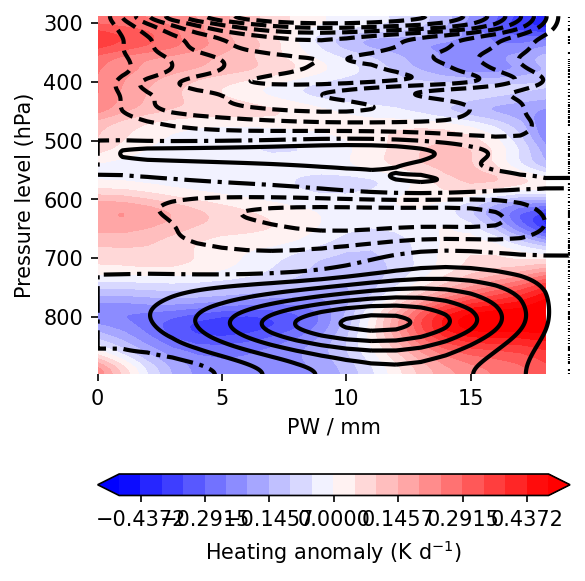

In [323]:
fig = plt.figure(figsize=plt.figaspect(1), dpi=150)
ax  = plt.subplot(111)
bound = np.nanmax([np.abs(np.nanpercentile(Q_anomaly_smooth_anomaly_sel,1)),
                            np.abs(np.nanpercentile(Q_anomaly_smooth_anomaly_sel,99))])
cq1 = ax.contourf(np.arange(len(Q_anomaly_smooth_anomaly_sel)),
                  ds_radiation_mean.pressure.mean(dim="pw_bins")/100,
                  Q_anomaly_smooth_anomaly_sel.T,cmap="bwr",
                  levels=np.linspace(-bound,+bound,21),
                  extend="both")
bound_ = np.nanmax([np.abs(np.nanpercentile(psi_smooth.T,1)),
                            np.abs(np.nanpercentile(psi_smooth.T,99))])

p1  = ax.contour(np.arange(len(omega_clear_smooth_anomaly_sel)+1),
                 ds_radiation_mean.pressure.mean(dim="pw_bins")/100,psi_smooth.T[:,:],colors='k',
                 levels=np.linspace(-bound_,+bound_,17),
                 interpolation="none",extend="both", linewidths=2) #21 lines
p1.collections[8].set_linestyle('-.')

print("The contourlines are drawn from {} to {} with 20 intervals".format(-bound,+bound))
ax.set_xlabel(r'PW / mm')
# ax.set_xticklabels(['0','20','40','60','80','100'])
cb  = fig.colorbar(cq1, ax=ax,fraction=0.08,orientation="horizontal",pad=0.2)
cb.set_label(r"Heating anomaly (K d$^{-1}$)")

ax.set_ylabel("Pressure level (hPa)")
ax.invert_yaxis()
plt.gca().spines['left'].set_color('none')
plt.gca().spines['bottom'].set_color('none')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.tight_layout()
plt.show()

## Ignore days with Ac clouds
The Ac layer that was present at least for 14.2.2020 - 16.2.2020 has a clear influence on the radiative heating cross section in moisture space. Because this layer has so far not been associated with any particular pattern, we disregard those days in the following to get a more ideal/informative picture.